In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

2022-12-25 23:24:37.756900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_SIZE = (300, 300)
batch_size = 64
num_epochs = 50
NUM_CLASSES = 5

In [3]:
# Bands used for CNN classification
bands = ['B3', 'B4', 'B8', 'B8A', 'B11', 'B12']

In [4]:
# Loading dataset csv
labels = pd.read_csv('./classes/labels.csv')

# Split data set to train and validation
train_labels, valid_labels = train_test_split(labels, test_size=0.2, random_state=101)
print(train_labels.shape, valid_labels.shape)

(3110, 2) (778, 2)


In [6]:
# Class to load images (concatenate all bands to np arr) 
# and corresponding labels for training

class Sequence_generator(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, labels, bands, batch_size, img_size):
        self.batch_size = batch_size
        self.img_size = img_size
        self.labels = labels
        self.bands = bands

    def __len__(self):
        return len(self.labels) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_files = self.labels['file'][i: i + self.batch_size]
        x = np.zeros((self.batch_size,) +
                     self.img_size + (len(self.bands),), dtype="float32")
        for j, file_name in enumerate(batch_files):
            for b, band in enumerate(self.bands):
                img = load_img(
                    f'./classes/all_data/{band}/{file_name}',
                    target_size=self.img_size,
                    color_mode='grayscale'
                )
                x[j, :, :, b] = img

        l = self.labels['label'][i: i+self.batch_size].to_numpy(dtype='uint8')
        y = np.zeros((l.size, NUM_CLASSES))
        y[np.arange(l.size), l] = 1
        return x, y

    def on_epoch_end(self):
        self.labels = self.labels.sample(frac=1)
        return super().on_epoch_end()


In [7]:
from keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization)

In [8]:
# Creating a Keras sequential model
model = tf.keras.models.Sequential()

# Adding layers
model.add(Conv2D(16, (3, 3), strides=2, padding="same",      # 300,300
                 activation="relu", input_shape=IMG_SIZE+(len(bands),)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding="same"))      # 150,150
# model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=3, padding="same"))      # 75,75
# model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding="same"))

model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding="same"))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))


2022-12-25 23:24:40.999905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 23:24:41.549370: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-25 23:24:41.549410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1619 MB memory:  -> device: 0, name: NVIDIA GeForce MX110, pci bus id: 0000:01:00.0, compute capability: 5.0


In [10]:
# Optimizers, loss function and performance metrics
opt = 'Adamax'
cat_loss = tf.keras.losses.CategoricalCrossentropy()
acc_metrics = [tf.keras.metrics.CategoricalAccuracy()]

# Compiling the model
model.compile(optimizer=opt, loss=cat_loss, metrics=acc_metrics)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      880       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 38, 38, 32)       128       
 hNormalization)                                                 
                                                        

In [12]:
# plot_model(model, to_file=f'{model.name}.png', show_shapes=True, show_layer_names=True)

In [13]:
# Data generators for training and testing
train_gen = Sequence_generator(train_labels, bands, batch_size, IMG_SIZE)
valid_gen = Sequence_generator(valid_labels, bands, batch_size, IMG_SIZE)

In [14]:
x = train_gen[0]
x[0].shape

(64, 300, 300, 6)

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "./cnn_weights/CNN_classification_{val_categorical_accuracy:.3f}.h5", 
        monitor='val_categorical_accuracy', 
        save_best_only=True
    )
]

In [16]:
mh = model.fit(
    train_gen, 
    batch_size=batch_size,
    validation_data=valid_gen, 
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/50


2022-12-25 23:24:45.867472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2022-12-25 23:24:48.126237: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0300017350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-25 23:24:48.126265: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce MX110, Compute Capability 5.0
2022-12-25 23:24:48.129956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-25 23:24:48.222273: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 60s 1s/step - loss: 0.9672 - categorical_accuracy: 0.6816 - val_loss: 1.5911 - val_categorical_accuracy: 0.5365
Epoch 2/50
48/48 [==============================] - 52s 1s/step - loss: 0.6326 - categorical_accuracy: 0.7529 - val_loss: 1.0516 - val_categorical_accuracy: 0.5586
Epoch 3/50
48/48 [==============================] - 52s 1s/step - loss: 0.5752 - categorical_accuracy: 0.7806 - val_loss: 0.8373 - val_categorical_accuracy: 0.6667
Epoch 4/50
48/48 [==============================] - 52s 1s/step - loss: 0.5033 - categorical_accuracy: 0.7998 - val_loss: 0.6243 - val_categorical_accuracy: 0.7630
Epoch 5/50
48/48 [==============================] - 52s 1s/step - loss: 0.4842 - categorical_accuracy: 0.8047 - val_loss: 0.5567 - val_categorical_accuracy: 0.7878
Epoch 6/50
48/48 [==============================] - 52s 1s/step - loss: 0.4419 - categorical_accuracy: 0.8161 - val_loss: 0.5372 - val_categorical_accuracy: 0.8021
Epoch 7/50
48/48 [=========

In [17]:
v_acc = mh.history['val_categorical_accuracy'][-1]
model.save(f'{model.name}_{v_acc:.4f}.h5')

In [18]:
train_acc = mh.history['categorical_accuracy']
train_loss = mh.history['loss']

val_acc = mh.history['val_categorical_accuracy']
val_loss = mh.history['val_loss']

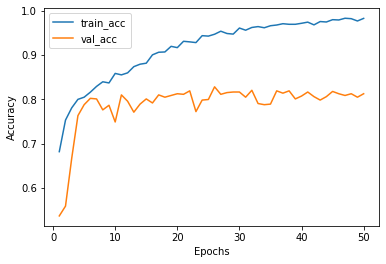

In [19]:
# Plot Epochs Vs. training and validation accuracy
acc_df = pd.DataFrame(zip(train_acc,val_acc), columns = ['train_acc', 'val_acc'])
acc_df.index = np.arange(1,len(acc_df)+1,1)
acc_df[['train_acc', 'val_acc']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

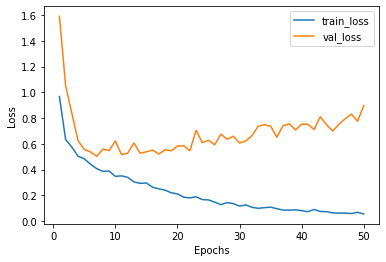

In [20]:
# Plot Epochs Vs. training and validation loss
los_df = pd.DataFrame(zip(train_loss,val_loss), columns = ['train_loss', 'val_loss'])
los_df.index = np.arange(1,len(los_df)+1,1)
los_df[['train_loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()